In [1]:
import argparse
import pandas as pd
import xgboost as xgb

from src.dataset import load_team_data, load_agg_player_data
from src.evaluate import evaluate_model
from src.postprocessing import  compute_prediction, save_predictions
from src.preprocessing import impute_missing_values, split_data, remove_name_columns, encode_target_variable

In [2]:
def parse_args(args):
    parser = argparse.ArgumentParser(description="XGBoost baseline for the QRT Challenge", prog="python baseline.py")
    parser.add_argument("--submit", action="store_true")
    parser.add_argument("--wandb", type=bool, default=False)

    parser.add_argument("--num_boost_round", type=int, default=1000)
    parser.add_argument("--early_stopping_rounds", type=int, default=10)

    parser.add_argument("--eta", type=float, default=0.3)
    parser.add_argument("--gamma", type=float, default=0)
    parser.add_argument("--max_depth", type=int, default=6)
    parser.add_argument("--min_child_weight", type=float, default=1)
    parser.add_argument("--subsample", type=float, default=1)
    parser.add_argument("--colsample_bytree", type=float, default=1)
    parser.add_argument("--colsample_bylevel", type=float, default=1)
    parser.add_argument("--colsample_bynode", type=float, default=1)
    parser.add_argument("--l2_reg", type=float, default=1)
    parser.add_argument("--l1_reg", type=float, default=0)
    parser.add_argument("--max_delta_step", type=float, default=0)
    parser.add_argument("--max_leaves", type=int, default=0)

    args = parser.parse_args(args.split())

    args_xgb = argparse.Namespace(num_boost_round=args.num_boost_round, 
                                    early_stopping_rounds=args.early_stopping_rounds
    )

    booster_params = {
        "eta": args.eta,
        "gamma": args.gamma,
        "max_depth": args.max_depth,
        "min_child_weight": args.min_child_weight,
        "subsample": args.subsample,
        "colsample_bytree": args.colsample_bytree,
        "colsample_bylevel": args.colsample_bylevel,
        "colsample_bynode": args.colsample_bynode,
        "lambda": args.l2_reg,
        "alpha": args.l1_reg,
        "max_delta_step": args.max_delta_step,
        "max_leaves": args.max_leaves,
    }

    return args, args_xgb, booster_params


In [8]:
def train_xgb_model(args):
    # === Parse command line arguments ===
    args, args_xgb, booster_params = parse_args(args)
    # ====================================

    # === Load and preprocess data ===
    team_statistics, y = load_team_data()
    player_statistics = load_agg_player_data()
    x = pd.concat([team_statistics, player_statistics], axis=1, join='inner')

    x = remove_name_columns(x)
    y = encode_target_variable(y)
    (x_train, y_train), (x_val, y_val), (x_test, y_test) = split_data(x, y)

    x_train, imputer, columns = impute_missing_values(x_train)
    x_val, _, _ = impute_missing_values(x_val, imputer=imputer, numeric_columns=columns)
    x_test, _, _ = impute_missing_values(x_test, imputer=imputer, numeric_columns=columns)
    # ================================

    # === Define model parameters ===
    booster_params["booster"] = "gbtree"
    booster_params["device"] = "cuda"

    booster_params["objective"] = "multi:softmax"
    booster_params["num_class"] = 3
    booster_params["eval_metric"] = "merror"
    booster_params["tree_method"] = "hist"
    booster_params["verbosity"] = 0

    num_boost_round = args_xgb.num_boost_round
    early_stopping_rounds = args_xgb.early_stopping_rounds
    # ===============================

    # === Train model ===
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dval = xgb.DMatrix(x_val, label=y_val)
    dtest = xgb.DMatrix(x_test, label=y_test)
    evals = [(dtrain, "train"), (dval, "val")]
    bst = xgb.train(booster_params, dtrain, num_boost_round=num_boost_round, evals=evals, early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
    # ===================

    # === Evaluate model ===
    acc_val = evaluate_model(bst, dval, y_val)
    acc_test = evaluate_model(bst, dtest, y_test)
    # ======================

    return bst, acc_val, acc_test

In [6]:
run_args = [
    "--colsample_bylevel=0.4984424650238812 --colsample_bynode=0.9905597373489496 --colsample_bytree=0.36486202458245887 --early_stopping_rounds=20 --eta=0.26805672230829103 --gamma=6.68112740309121 --l1_reg=0.4707151922876891 --l2_reg=1.320921390316153 --max_delta_step=5.084675132974765 --max_depth=9 --max_leaves=2 --min_child_weight=0.8216661936802998 --num_boost_round=1620 --subsample=0.8203148837326393",
    "--colsample_bylevel=0.6739479861331057 --colsample_bynode=0.8208024758661518 --colsample_bytree=0.2925799133602034 --early_stopping_rounds=15 --eta=0.200929936957491 --gamma=6.797139433915103 --l1_reg=1.056448594686562 --l2_reg=0.8864999144734944 --max_delta_step=4.492214931871299 --max_depth=12 --max_leaves=15 --min_child_weight=0.6330043914809966 --num_boost_round=1352 --subsample=0.6926637801275177",
    "--colsample_bylevel=0.39832358343129226 --colsample_bynode=0.8257419459283301 --colsample_bytree=0.6216930361789222 --early_stopping_rounds=17 --eta=0.26770438860289286 --gamma=6.238120935652409 --l1_reg=0.014380291689163547 --l2_reg=1.446103262643319 --max_delta_step=0.6482196278101204 --max_depth=12 --max_leaves=13 --min_child_weight=0.4426638341956868 --num_boost_round=1439 --subsample=0.8674165810350483",
    "--colsample_bylevel=0.9695503356990438 --colsample_bynode=0.6766838220949988 --colsample_bytree=0.38254963707707024 --early_stopping_rounds=20 --eta=0.3658528328890789 --gamma=5.90151157244261 --l1_reg=0.27640343290368685 --l2_reg=1.5993198918718083 --max_delta_step=2.560626551186762 --max_depth=8 --max_leaves=10 --min_child_weight=0.590882622125941 --num_boost_round=1557 --subsample=0.5067593159912512",
    "--colsample_bylevel=0.2787274160427867 --colsample_bynode=0.32363284478737997 --colsample_bytree=0.5689444261417986 --early_stopping_rounds=14 --eta=0.29228876388169545 --gamma=7.6894952824566785 --l1_reg=0.7965409134707075 --l2_reg=1.033813442033938 --max_delta_step=8.821100614597096 --max_depth=8 --max_leaves=9 --min_child_weight=0.2014559088101171 --num_boost_round=1941 --subsample=0.9912143610674682",
]

run_names = [
    "rosy-sweep-47",
    "peachy-sweep-51",
    "charmed-sweep-67",
    "summer-sweep-71",
    "glowing-sweep-19",
]

In [9]:
from tqdm import tqdm

models, acc_vals, acc_tests = [], [], []
for args in tqdm(run_args, desc="Training models"):
    model, acc_val, acc_test = train_xgb_model(args)
    models.append(model)
    acc_vals.append(acc_val)
    acc_tests.append(acc_test)

Training models: 100%|██████████| 5/5 [01:55<00:00, 23.18s/it]


In [10]:
print("Validation accuracies:", acc_vals)
print("Test accuracies:", acc_tests)

Validation accuracies: [0.5043169121381412, 0.5134586084306755, 0.5078720162519045, 0.5043169121381412, 0.5043169121381412]
Test accuracies: [0.5046728971962616, 0.5014221861032101, 0.5014221861032101, 0.5002031694433158, 0.4997968305566843]


In [11]:
def get_features_importance(bst):
    feature_importance = bst.get_score(importance_type="gain")
    feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    feature_importance = pd.DataFrame(feature_importance, columns=["feature", "importance"])
    feature_importance = feature_importance.set_index("feature")
    return feature_importance

In [12]:
features_importances = [get_features_importance(model) for model in models]

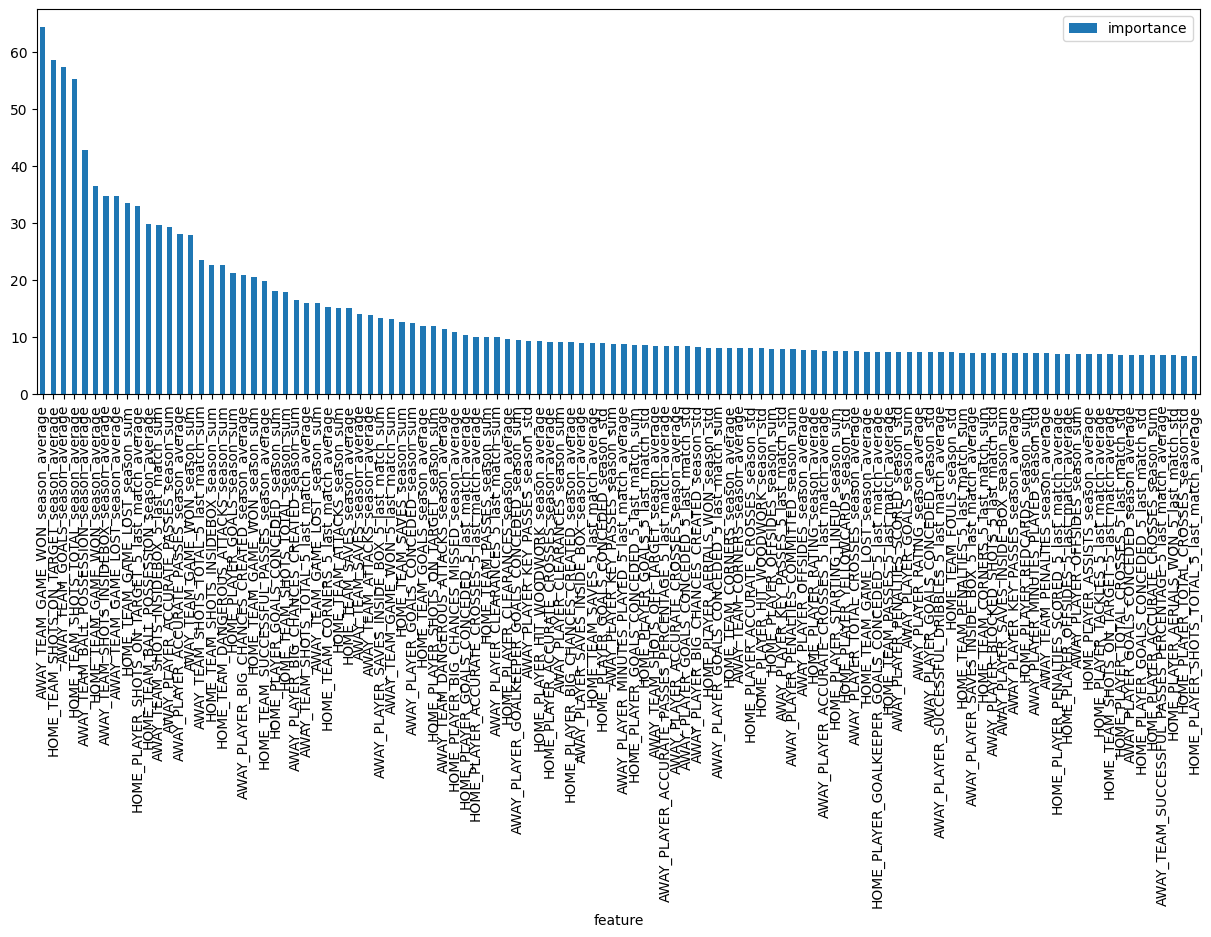

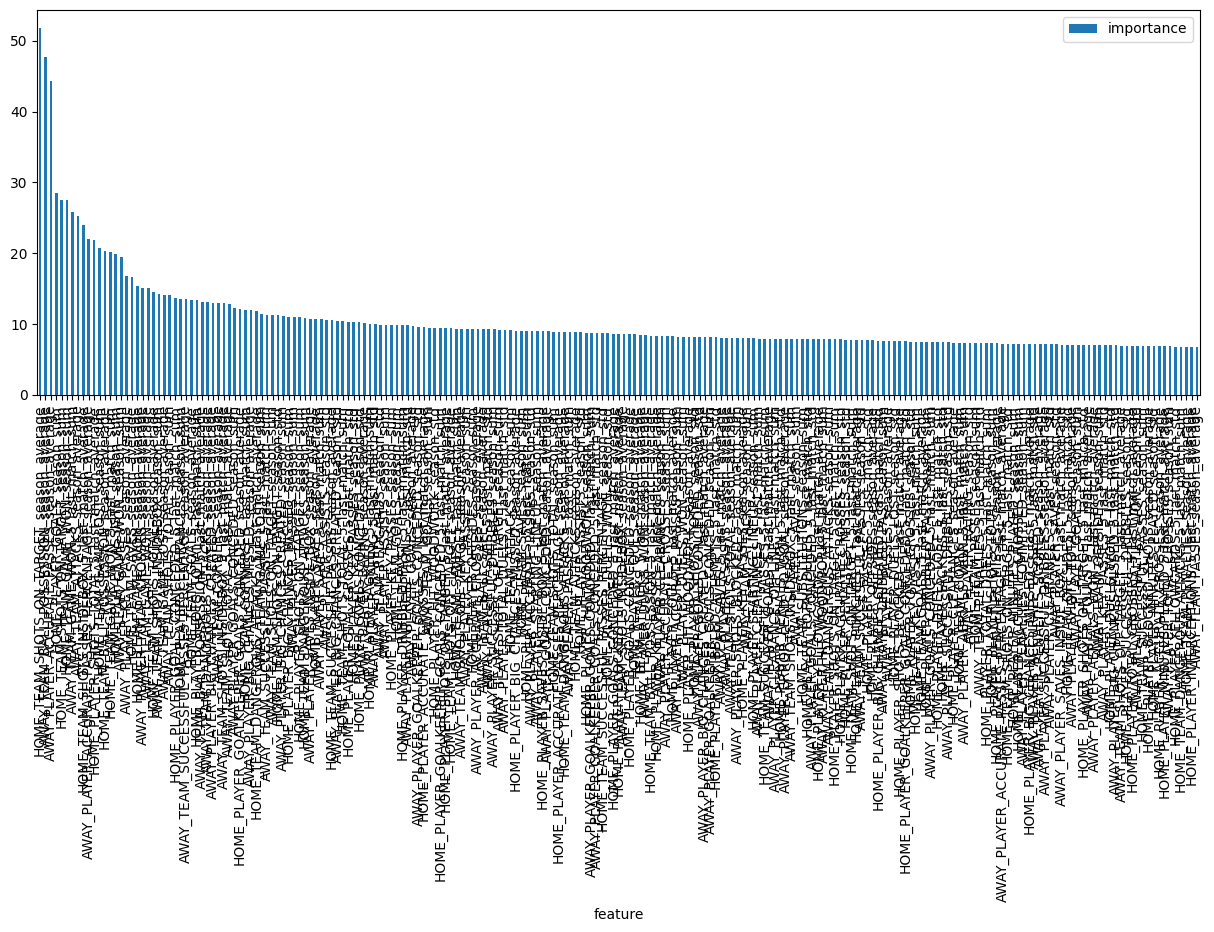

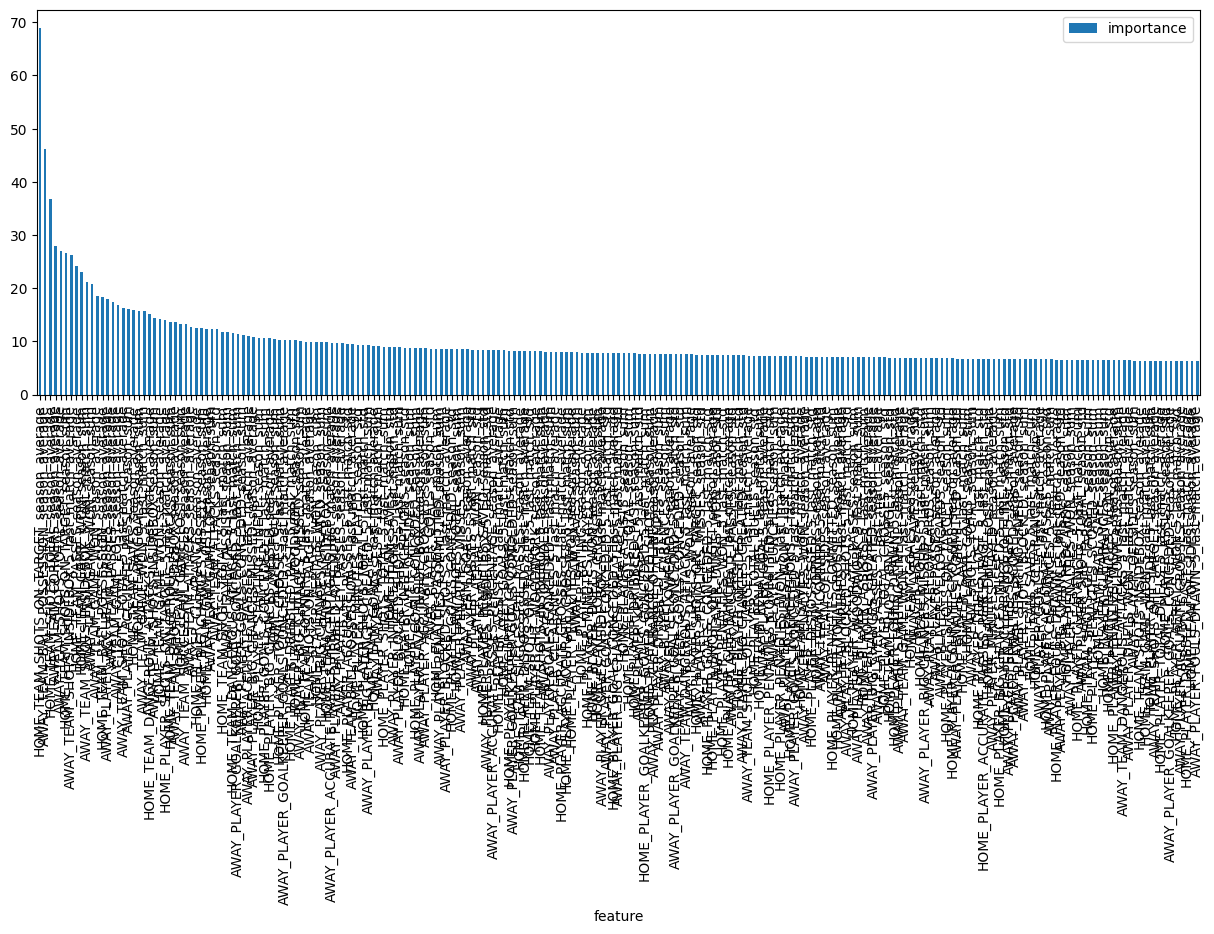

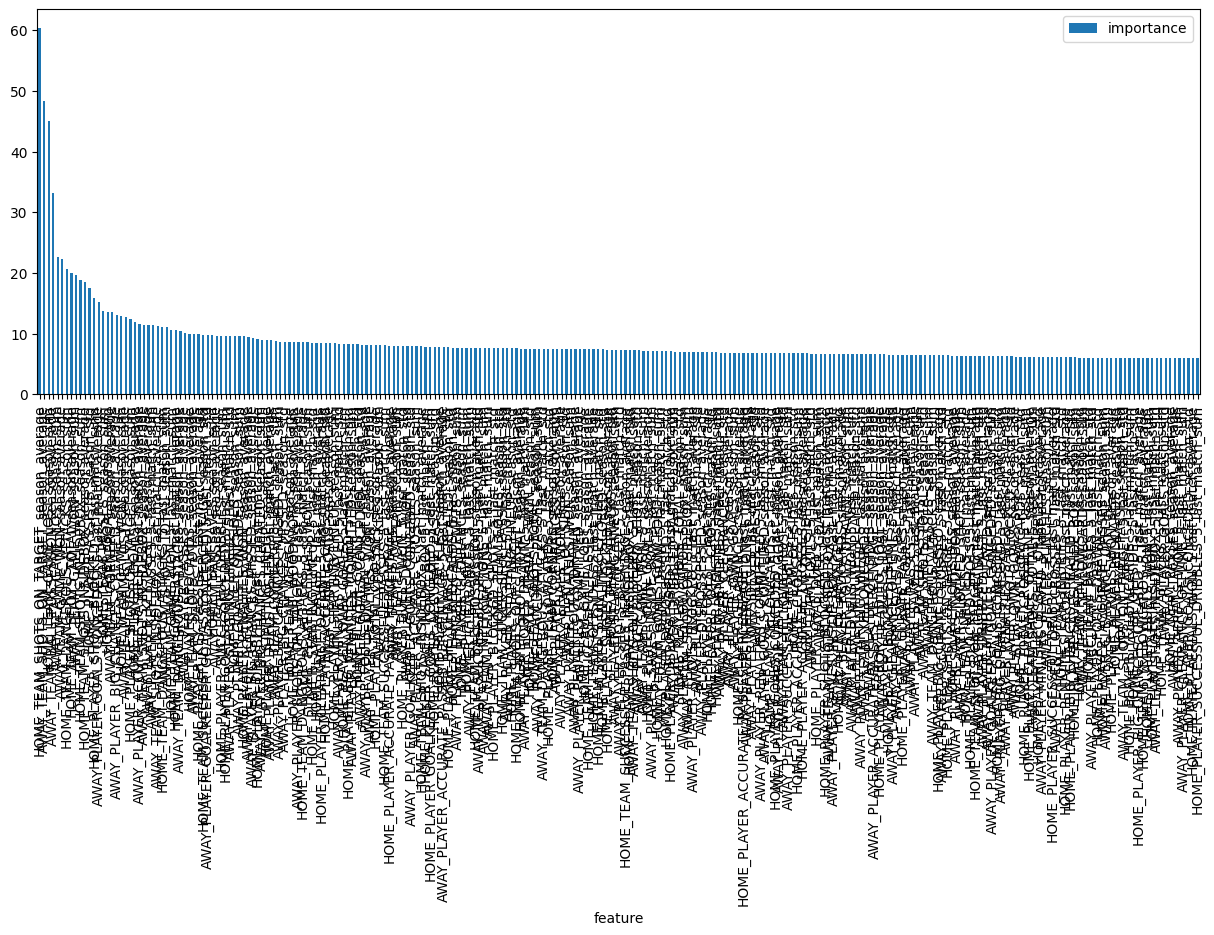

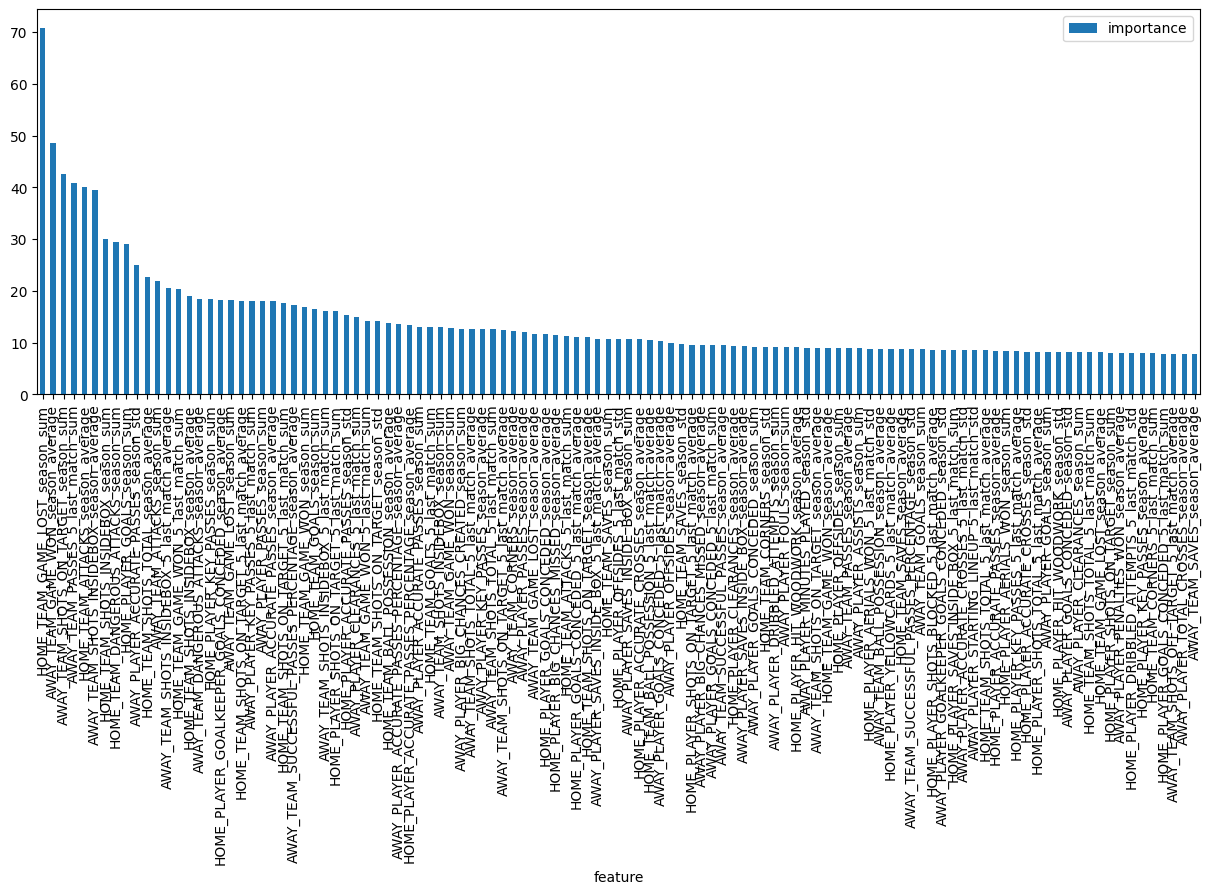

In [13]:
import matplotlib.pyplot as plt

for features_importance in features_importances:
    features_importance.plot(kind="bar", figsize=(15, 5))
    plt.show()

In [18]:
number_of_features = [len(features_importance) for features_importance in features_importances]
min_number_of_features = min(number_of_features)

In [21]:
top_k_features = [features_importance[:min_number_of_features] for features_importance in features_importances]

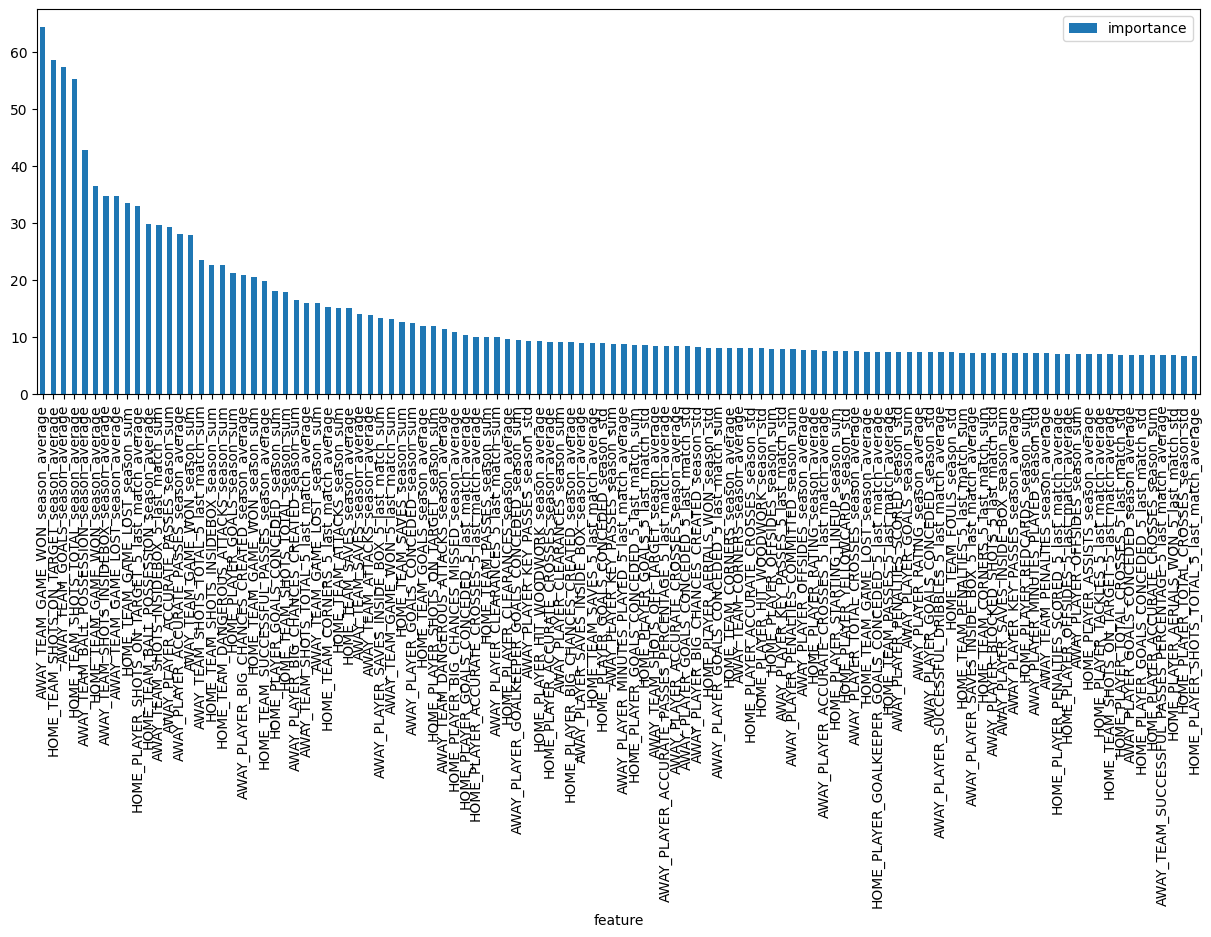

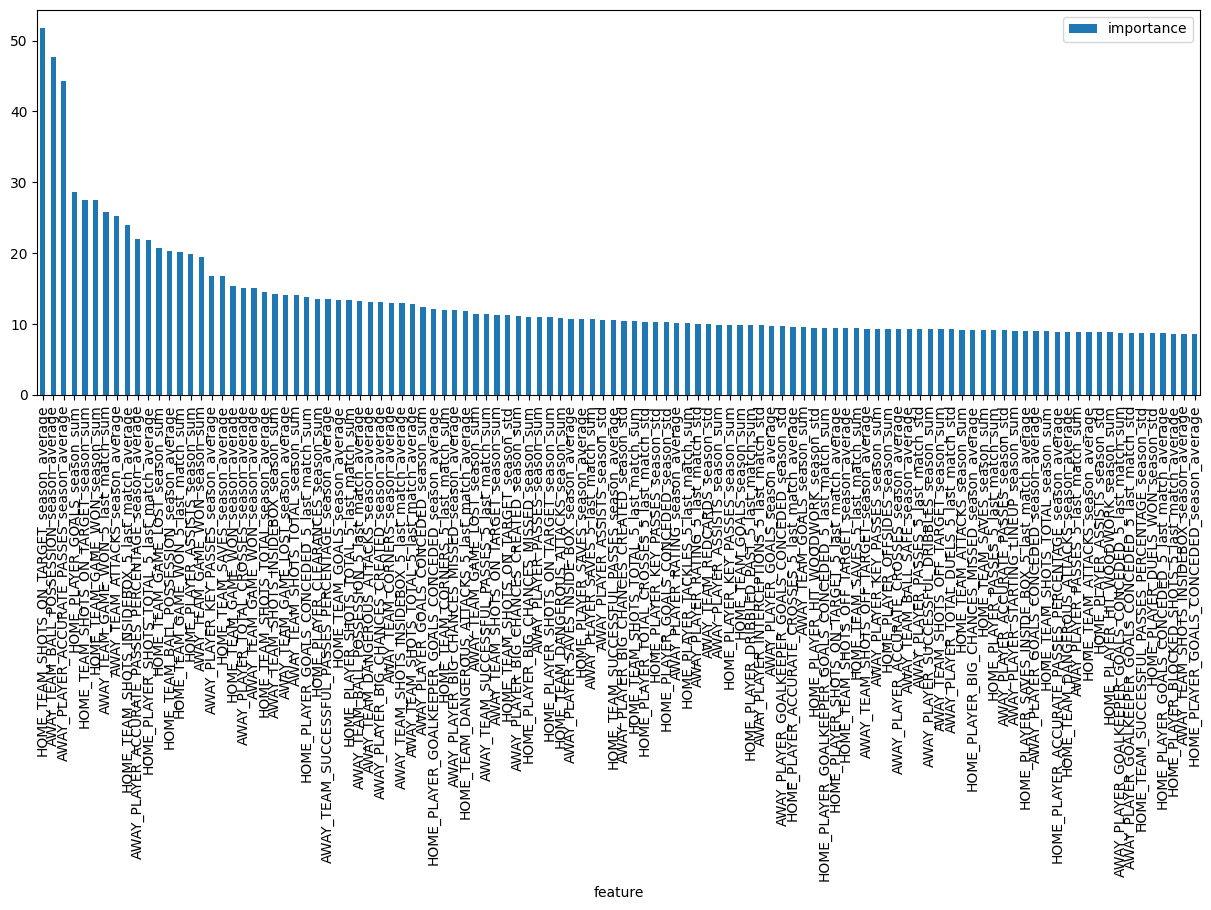

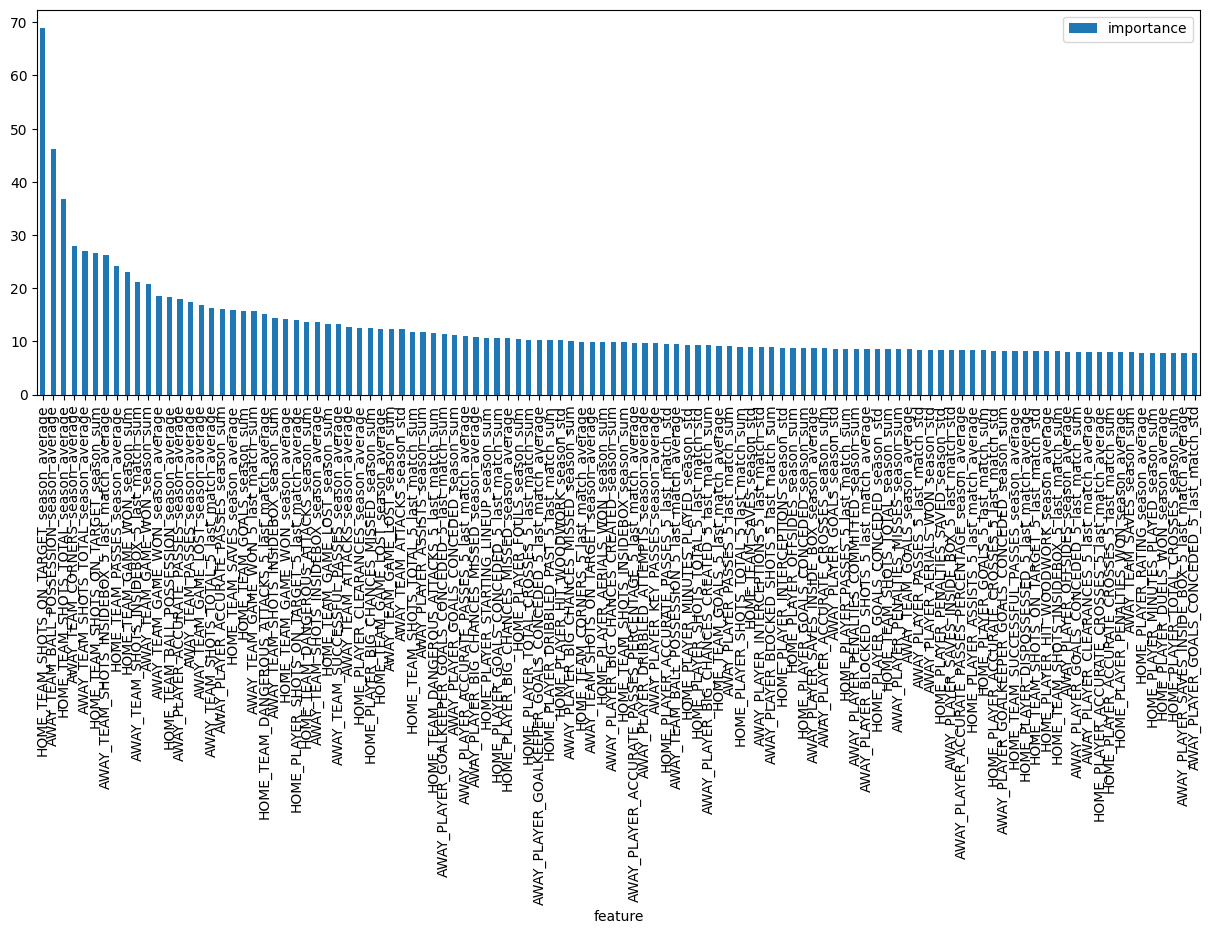

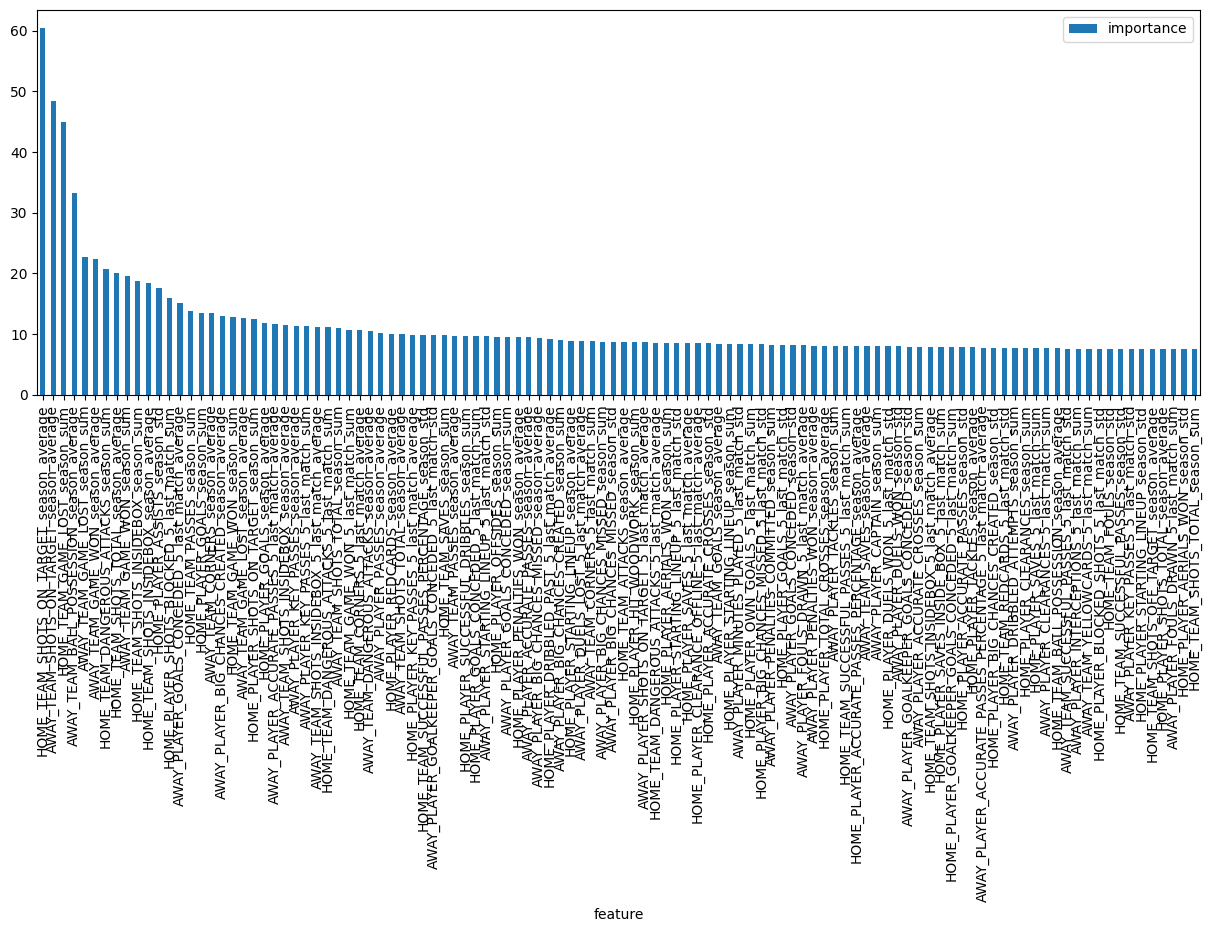

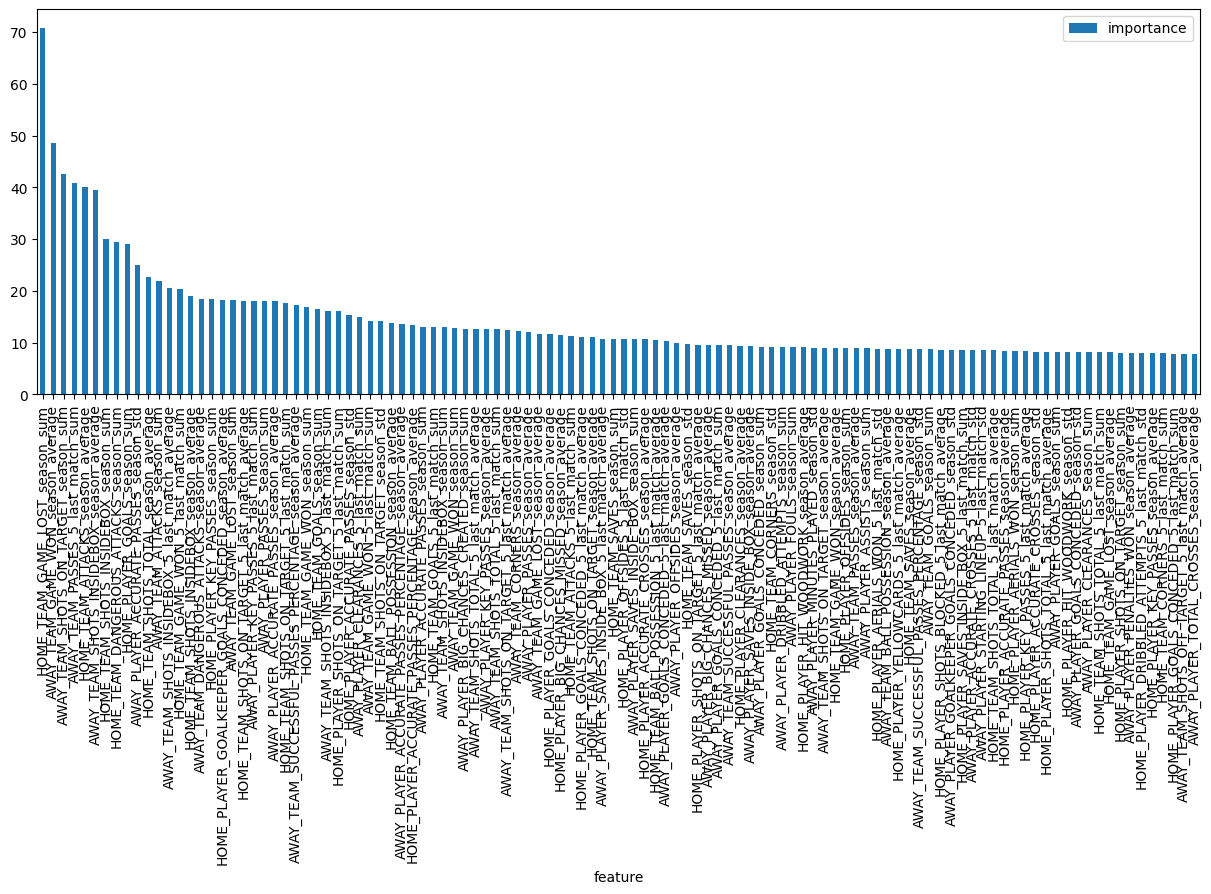

In [22]:
for features_importance in top_k_features:
    features_importance.plot(kind="bar", figsize=(15, 5))
    plt.show()

In [25]:
cross_features = set(top_k_features[0].index)
for features_importance in top_k_features[1:]:
    cross_features = cross_features.intersection(set(features_importance.index))
cross_features = list(cross_features)

['AWAY_TEAM_GAME_WON_season_average',
 'HOME_PLAYER_GOALS_CONCEDED_5_last_match_sum',
 'AWAY_TEAM_GAME_LOST_season_average',
 'HOME_TEAM_SHOTS_ON_TARGET_season_average',
 'AWAY_TEAM_CORNERS_season_average',
 'HOME_TEAM_DANGEROUS_ATTACKS_season_sum',
 'AWAY_TEAM_SHOTS_INSIDEBOX_season_average',
 'HOME_TEAM_GAME_WON_season_sum',
 'AWAY_TEAM_BALL_POSSESSION_season_average',
 'AWAY_PLAYER_BIG_CHANCES_CREATED_season_sum',
 'AWAY_TEAM_GAME_WON_season_sum',
 'AWAY_PLAYER_KEY_PASSES_season_average',
 'HOME_TEAM_SHOTS_TOTAL_season_average',
 'AWAY_TEAM_GAME_LOST_season_sum',
 'HOME_TEAM_BALL_POSSESSION_season_average',
 'HOME_PLAYER_OFFSIDES_season_sum',
 'HOME_TEAM_GAME_LOST_season_sum',
 'AWAY_PLAYER_GOALS_CONCEDED_season_sum',
 'AWAY_PLAYER_ACCURATE_PASSES_season_average']

In [27]:
import numpy as np

def find_knee_point(y):
    dy = np.diff(y)
    ddy = np.diff(dy)
    knee_idx = np.argmax(ddy) + 1
    return knee_idx

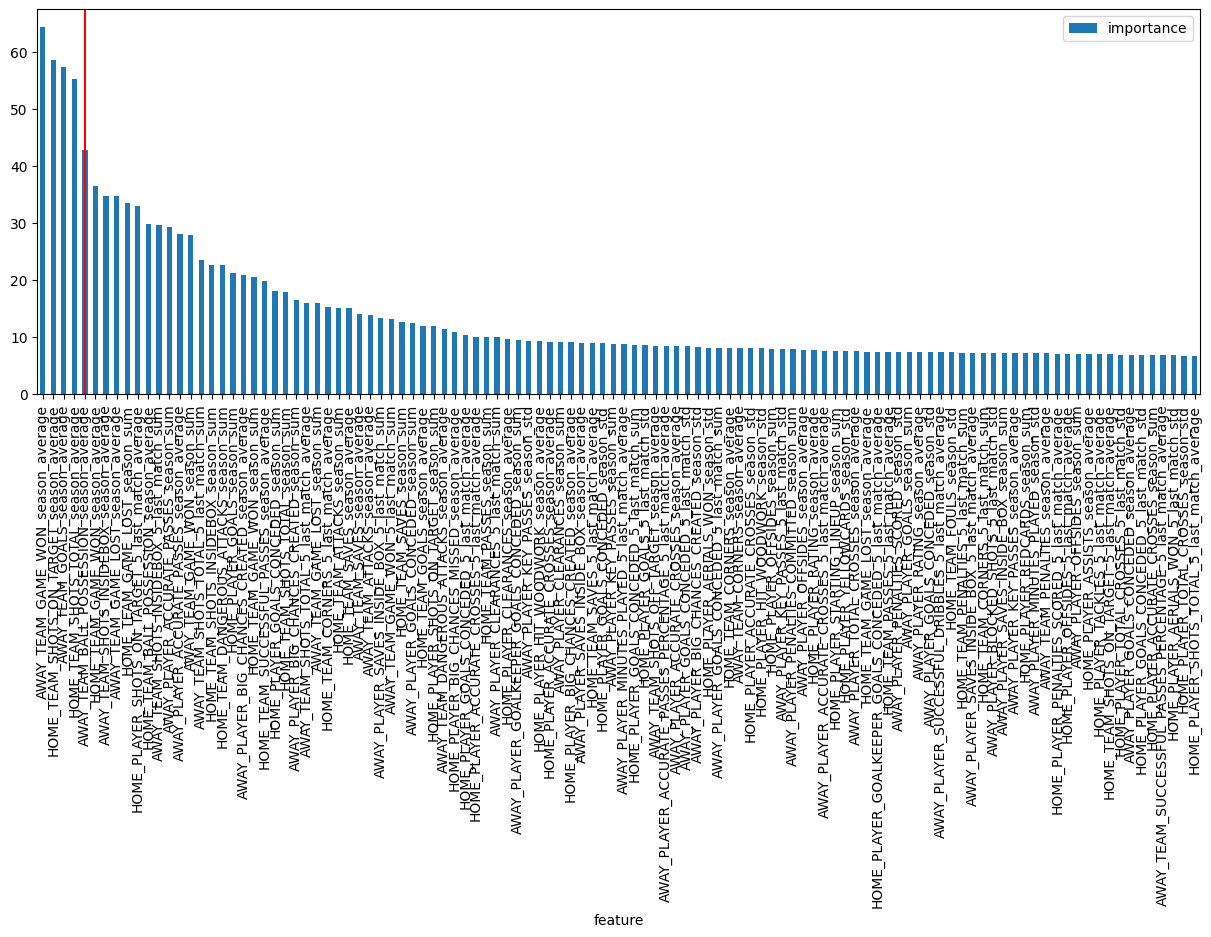

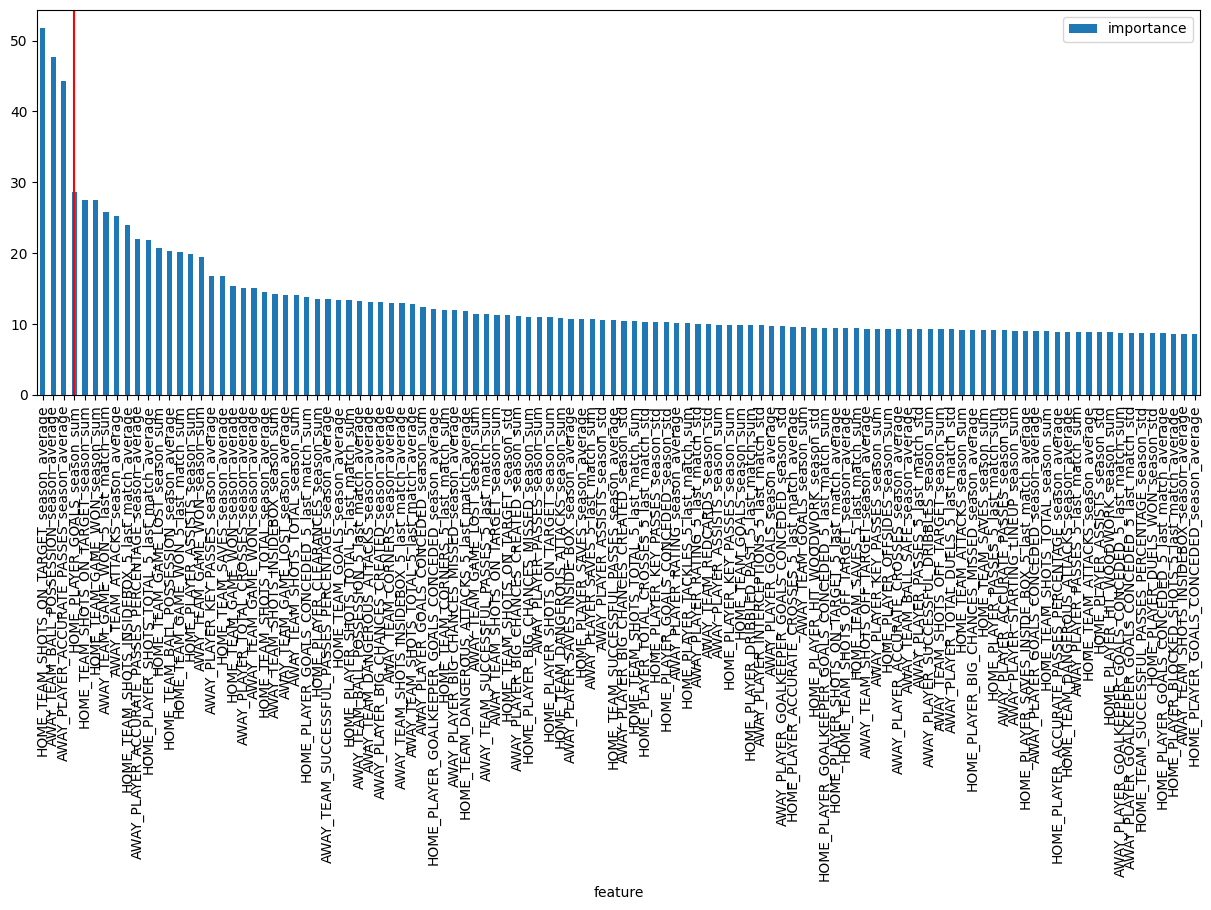

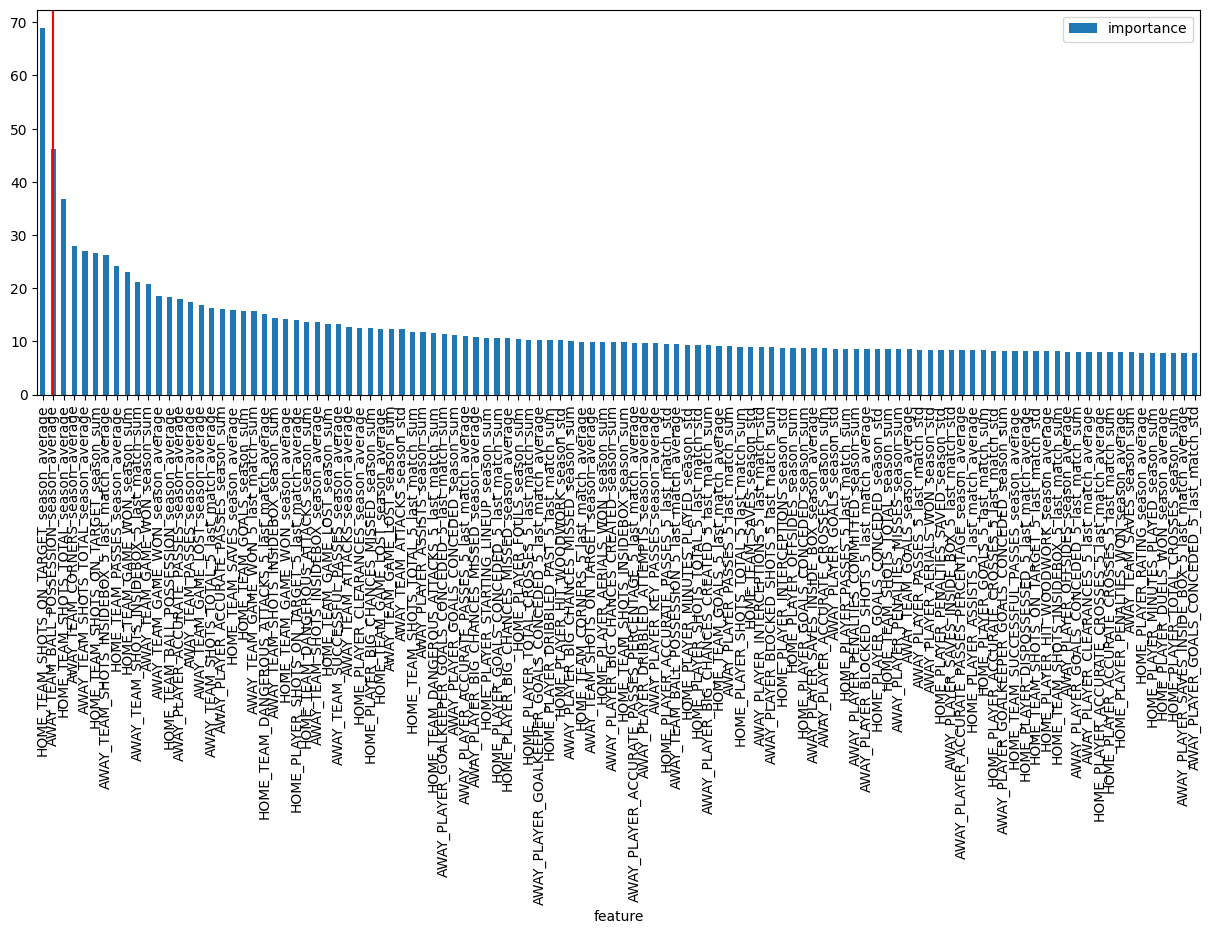

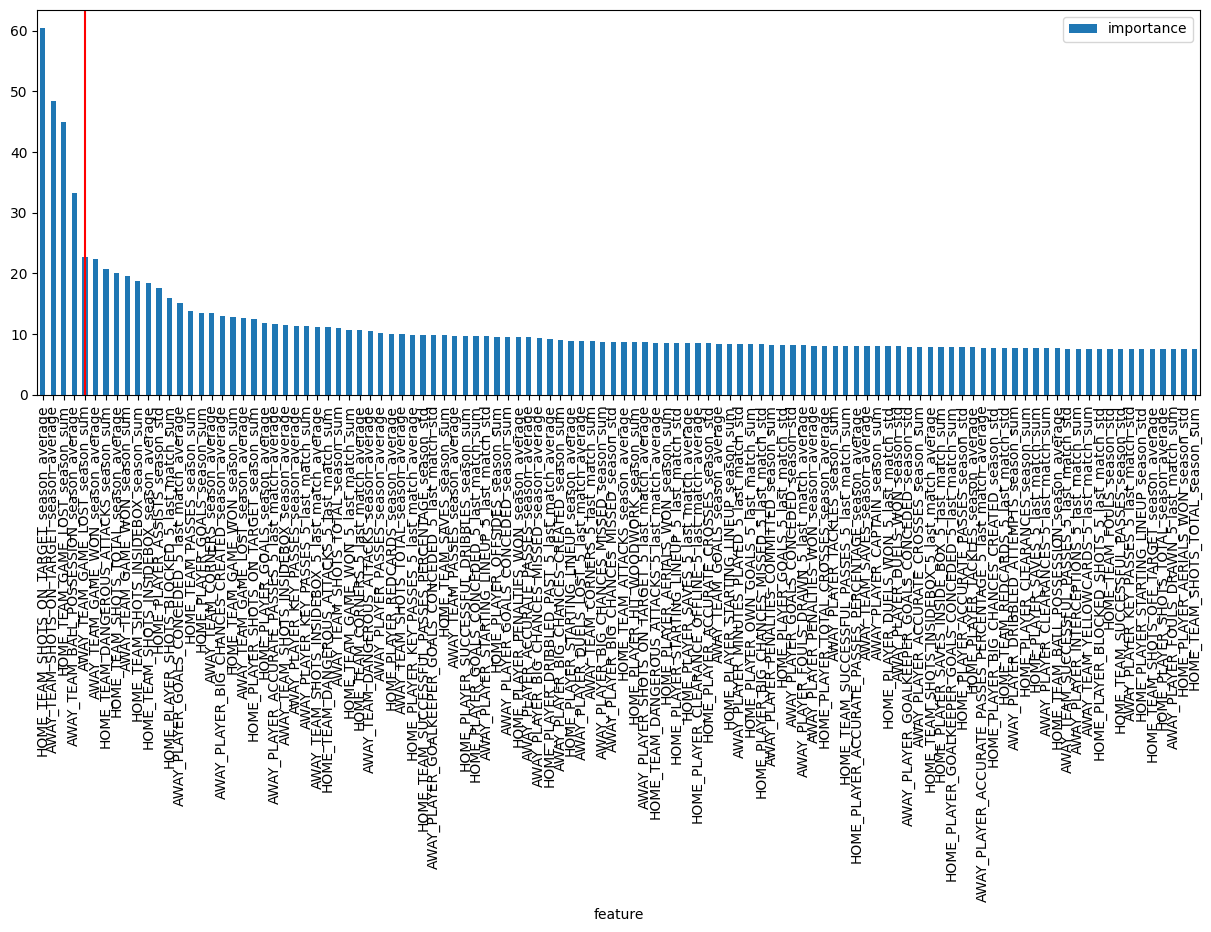

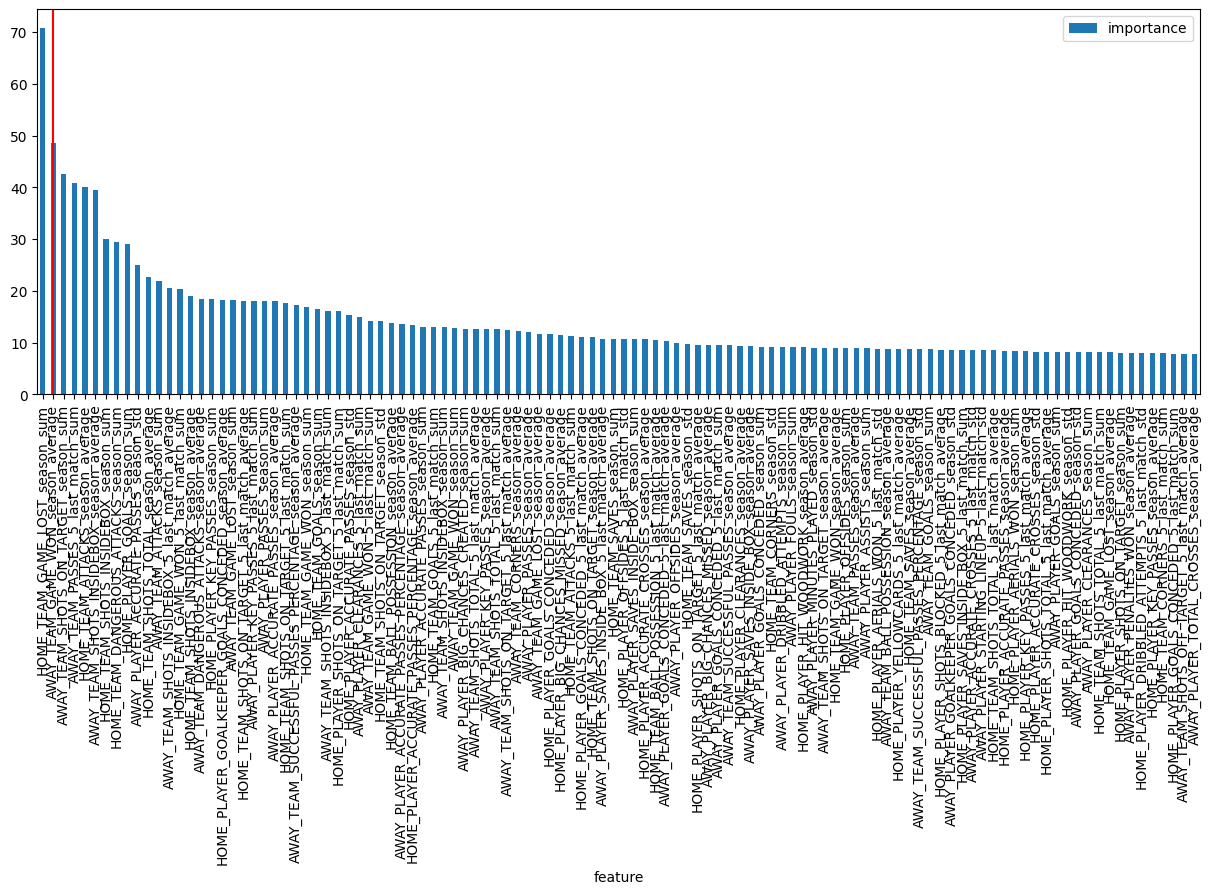

In [33]:
knee_points = [find_knee_point(features_importance.importance.values) for features_importance in top_k_features]

for features_importance, knee_point in zip(top_k_features, knee_points):
    features_importance.plot(kind="bar", figsize=(15, 5))
    plt.axvline(x=knee_point, color="red")
    plt.show()

In [49]:
knee_point_features_list = [features_importance[:knee_point] for features_importance, knee_point in zip(top_k_features, knee_points)]

In [50]:
knee_point_features = set(knee_point_features_list[0].index)
for features_importance in knee_point_features_list[1:]:
    knee_point_features = knee_point_features.union(set(features_importance.index))
knee_point_features

{'AWAY_PLAYER_ACCURATE_PASSES_season_average',
 'AWAY_TEAM_BALL_POSSESSION_season_average',
 'AWAY_TEAM_GAME_WON_season_average',
 'AWAY_TEAM_GOALS_season_average',
 'AWAY_TEAM_SHOTS_ON_TARGET_season_average',
 'HOME_TEAM_GAME_LOST_season_sum',
 'HOME_TEAM_SHOTS_ON_TARGET_season_average',
 'HOME_TEAM_SHOTS_TOTAL_season_average'}

In [53]:
best_features = knee_point_features.union(cross_features)
best_features

{'AWAY_PLAYER_ACCURATE_PASSES_season_average',
 'AWAY_PLAYER_BIG_CHANCES_CREATED_season_sum',
 'AWAY_PLAYER_GOALS_CONCEDED_season_sum',
 'AWAY_PLAYER_KEY_PASSES_season_average',
 'AWAY_TEAM_BALL_POSSESSION_season_average',
 'AWAY_TEAM_CORNERS_season_average',
 'AWAY_TEAM_GAME_LOST_season_average',
 'AWAY_TEAM_GAME_LOST_season_sum',
 'AWAY_TEAM_GAME_WON_season_average',
 'AWAY_TEAM_GAME_WON_season_sum',
 'AWAY_TEAM_GOALS_season_average',
 'AWAY_TEAM_SHOTS_INSIDEBOX_season_average',
 'AWAY_TEAM_SHOTS_ON_TARGET_season_average',
 'HOME_PLAYER_GOALS_CONCEDED_5_last_match_sum',
 'HOME_PLAYER_OFFSIDES_season_sum',
 'HOME_TEAM_BALL_POSSESSION_season_average',
 'HOME_TEAM_DANGEROUS_ATTACKS_season_sum',
 'HOME_TEAM_GAME_LOST_season_sum',
 'HOME_TEAM_GAME_WON_season_sum',
 'HOME_TEAM_SHOTS_ON_TARGET_season_average',
 'HOME_TEAM_SHOTS_TOTAL_season_average'}

In [70]:
feature_names = [best_feature[5:] for best_feature in best_features]
feature_names = set(feature_names)
feature_names = pd.Series(list(feature_names))
feature_names

0                  TEAM_GOALS_season_average
1                 PLAYER_OFFSIDES_season_sum
2        TEAM_BALL_POSSESSION_season_average
3        TEAM_SHOTS_ON_TARGET_season_average
4      PLAYER_BIG_CHANCES_CREATED_season_sum
5           PLAYER_KEY_PASSES_season_average
6                TEAM_CORNERS_season_average
7            TEAM_SHOTS_TOTAL_season_average
8                  TEAM_GAME_LOST_season_sum
9           PLAYER_GOALS_CONCEDED_season_sum
10     PLAYER_ACCURATE_PASSES_season_average
11                  TEAM_GAME_WON_season_sum
12              TEAM_GAME_WON_season_average
13       TEAM_SHOTS_INSIDEBOX_season_average
14    PLAYER_GOALS_CONCEDED_5_last_match_sum
15             TEAM_GAME_LOST_season_average
16         TEAM_DANGEROUS_ATTACKS_season_sum
dtype: object

In [71]:
feature_names.to_csv("best_features_team_agg_based.csv", index=False)